# Mall Customer Segmentation

## Description

The current project addresses the problem posed on Kaggle, available at the following link: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data.

The context of the project is that you own (or, otherwise, work for) a mall. Through membership cards, you have some basic data about your customers, including *Customer ID, age, gender, annual income and spending score*. The *Spending Score* is a metric that has been assigned to customers based on their customer behavior and purchasing data.

The primary objective is to identify customer segments from the data. This type of problem lends itself particularly well to unsupervised learning approaches. We will explore the use of K-means clustering, hierarchical clustering and DBSCAN clustering in this project.

The customer segments identified will ultimately be provided to the marketing team to achieve a variety of objectives, including:
- Identification of high-value customer segments for targeted campaigns
- Enhance customer satisfaction and engagement by personalizing ad campaigns
- Optimize marketing spend by focusing on high-value customers
- Improve customer retention by better addressing the needs of customer segments

## Description of features

- Customer ID: unique ID assigned to customer
- Age: age of customer, continuous
- Gender: self-identified gender of customer, categorical
- Annual Income: self-reported annual income of customer, continuous
- Spending Score:  score dervied from customer behavior and purchasing data, continuous

## Import libraries

In [103]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

## Load data

In [90]:
# Load data
data = pd.read_csv('Mall_Customers.csv')

## Clean data

First, perform some preliminary data exploration.

In [76]:
print(data.shape)
print(data.info())

(200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [77]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [78]:
data['CustomerID'].duplicated().sum()

0

There are 200 rows of data, and 4 columns that can be used as features (CustomerID is not a relevant feature). As each Customer ID is unique, we can drop this variable. We'll also want to use one-hot encoder on the Gender variable and scale the continuous variables before splitting the data.

In [91]:
# Drop CustomerID variable
data = data.drop(['CustomerID'], axis=1)

# One-hot encoding of the gender feature
data_enc = pd.get_dummies(data, columns=['Gender'], drop_first=True)

# Scale numeric attributes
scaler = StandardScaler()
data_enc[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = \
    scaler.fit_transform(data_enc[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

## Exploratory Data Analysis (EDA)

So far, we have described the features of the dataset at a high-level. Now, we will take a deeper dive into exploring the features of the data.

In [92]:
# Check for missing values
print(data.isna().sum())

# Check for duplicated values -- this isn't necessarily an issue as we have dropped the CustomerID column
print("Number duplicates:", data.duplicated().sum())

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
Number duplicates: 0


In [93]:
# Explore summary satistics of variables
print(data.describe())
print(data.describe(include = "O"))

              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000
        Gender
count      200
unique       2
top     Female
freq       112


Now, let's visualize the distribution of features.

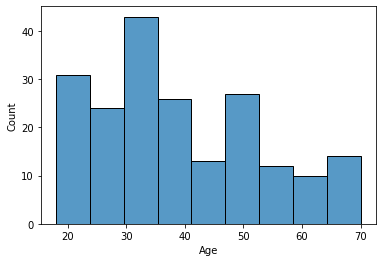

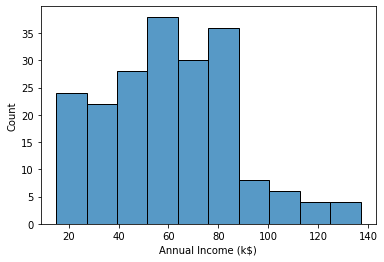

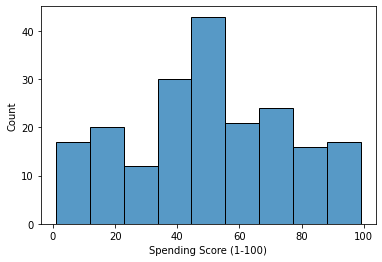

In [98]:
columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
for i in columns:
    plt.figure()
    sns.histplot(data[i])

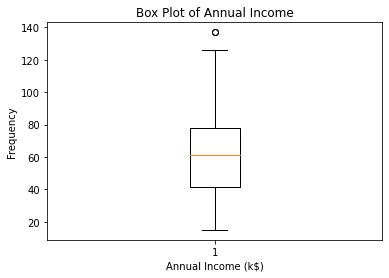

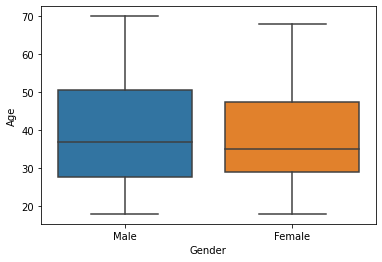

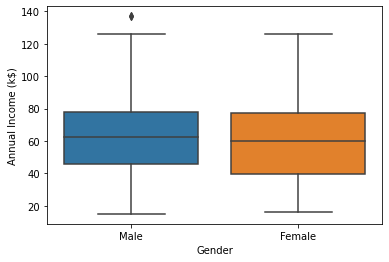

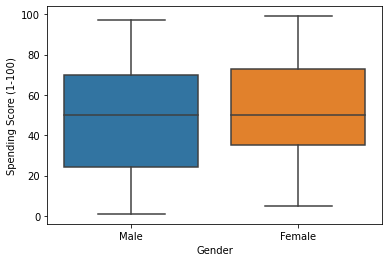

In [100]:
# Box plot of annual income
plt.boxplot(data['Annual Income (k$)'])
plt.xlabel('Annual Income (k$)')
plt.ylabel('Frequency')
plt.title('Box Plot of Annual Income')
plt.show()

# Bar plots of variables by gender
for i in columns:
    plt.figure()
    sns.boxplot(data = data, x = 'Gender', y = data[i])

The distribution of age is skewed to the left, and the distribution of income is skewed to the right. Although there are a few outliers for income (high income earners), the income of these individuals is not so high so as to signifcantly influence modeling. There are more females as compared to males, and the distribution of variables appears to be similar between genders.

There is no apparent need to conduct transformations of the data (e.g., log transformation).

Next, let's take a look at the correlation between features.

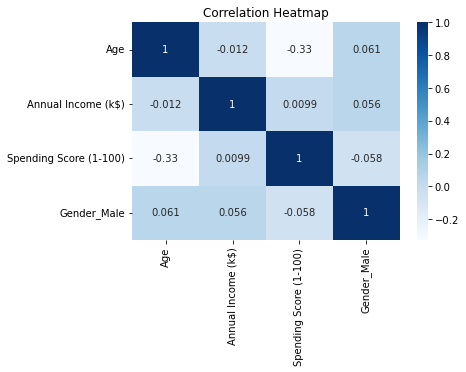

In [101]:
# Calculate correlation between features
corr_matrix = data_enc[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']].corr()

# Create heatmap of correlation matrix
sns.heatmap(corr_matrix, annot = True, cmap = 'Blues')
plt.title('Correlation Heatmap')
plt.show()

Based on the correlation heatmap, there are no strong associations detected between the features contained in the dataset. Given dataset contains 200 rows with 4 features, there is no need for dimensionality reduction.

## Perform Analyses

### K-Means Clustering

To create a targeted ad campaign, we'll begin by including information on all 4 features into our model:
- Age
- Annual Income
- Spending Score
- Income

First, we'll determine the optimal number of clusters using the elbow method.

In [108]:
# Calculate inertia scores for different number of clusters
inertia_scores = []
for i in range(1, 21):
    kmeans_model = KMeans(n_clusters=i)
    kmeans_model.fit(data_enc[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']])
    inertia_scores.append(kmeans_model.inertia_)

# Plot inertia scores by number of clusters
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = list(range(1, len(inertia_scores)+1)),
    y = inertia_scores,
    mode = 'lines+markers',
    name = 'Inertia Scores',
    line = dict(color = 'blue', width=1.5),
    marker = dict(color = 'blue', size=5)
))
fig.update_layout(
    title = 'KMeans Inertia Scores vs. Number of Clusters',
    xaxis_title = 'Number of Clusters',
    yaxis_title = 'Inertia Score'
)
fig.show()

C:\Users\SFortin1\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



The data may not be clearly clustered as reflected by the "elbow" not being clear and sharp in the figure above. This is to be expected in many real-world problems. That being said, it seems that the elbow is approimately at k=6; therefore, we'll use 6 clusters moving forward.

Let's train the K-Means model with k=6.

In [116]:
# Training the model with optimal no of clusters
kmeans_model = KMeans(n_clusters = 6, init = "k-means++", random_state = 42)
kmeans_labels = kmeans_model.fit_predict(data_enc)

To assess the appropriateness of clustering results, we'll use the Silhouette Score, which measures how similar a point is to its own cluster as compared to other clusters.

In [117]:
metrics.silhouette_score(data_enc, kmeans_model.labels_, metric = 'euclidean')

0.6200267012935324

Here are some general rules-of-thumb for interpretting silhouette scores:
- The silhouette score ranges between -1 to 1
- A value >0.7 is considered "strong"
- A value >0.5 is considered "reasonable"
- A value >0.25 is considered "weak"
- Higher values become difficult to achieve as the number of features increaes due to the curse of dimensionality

Our silhouette score is 0.62, which is good as it is above 0; and considered a "reasonable" fit.

Now, let's visualize the clusters. As our data contains 4 features, we'll focus on the most important features to display in our scatter plots.

In our 3-dimensional plot, we'll focus on:
- Age
- Annual Income (k$)
- Spending Score

In our 2-dimensional plot, we'll focus on:
- Annual Income (k$)
- Spending Score

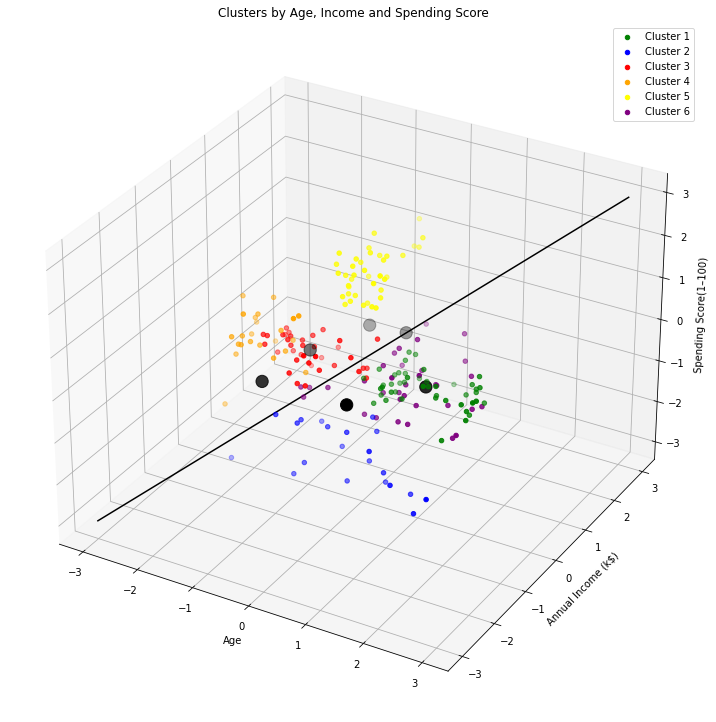

In [160]:
# Create plot
fig = plt.figure(figsize=(28,28))
kplot = fig.add_subplot(211, projection='3d')
#kplot = plt.axes(projection='3d')
xline = np.linspace(-3, 3, 1000)
yline = np.linspace(-3, 3, 1000)
zline = np.linspace(-3, 3, 1000)
kplot.plot3D(xline, yline, zline, 'black')


# Data for three-dimensional scattered points
kplot.scatter3D(data_enc.loc[kmeans_labels == 0]['Age'], data_enc.loc[kmeans_labels == 0]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 0]['Spending Score (1-100)'], c = 'green', label = 'Cluster 1')
kplot.scatter3D(data_enc.loc[kmeans_labels == 1]['Age'], data_enc.loc[kmeans_labels == 1]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 1]['Spending Score (1-100)'], c = 'blue', label = 'Cluster 2')
kplot.scatter3D(data_enc.loc[kmeans_labels == 2]['Age'], data_enc.loc[kmeans_labels == 2]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 2]['Spending Score (1-100)'], c = 'red', label = 'Cluster 3')
kplot.scatter3D(data_enc.loc[kmeans_labels == 3]['Age'], data_enc.loc[kmeans_labels == 3]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 3]['Spending Score (1-100)'], c = 'orange', label = 'Cluster 4')
kplot.scatter3D(data_enc.loc[kmeans_labels == 4]['Age'], data_enc.loc[kmeans_labels == 4]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 4]['Spending Score (1-100)'], c = 'yellow', label = 'Cluster 5')
kplot.scatter3D(data_enc.loc[kmeans_labels == 5]['Age'], data_enc.loc[kmeans_labels == 5]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 5]['Spending Score (1-100)'], c = 'purple', label = 'Cluster 6')

plt.scatter(kmeans_model.cluster_centers_[:, 0], 
            kmeans_model.cluster_centers_[:, 1],
            color = 'black', s = 150)
kplot.set_xlabel('Age')
kplot.set_ylabel('Annual Income (k$)')
kplot.set_zlabel('Spending Score(1–100)')
plt.legend()
plt.title("Clusters by Age, Income and Spending Score")
plt.show()

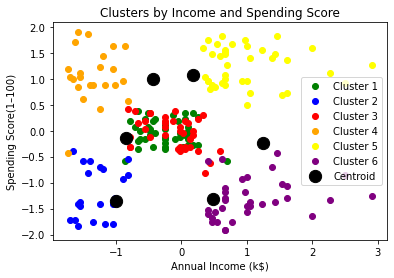

In [161]:
# visualizing the clusters
plt.scatter(data_enc.loc[kmeans_labels == 0]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 0]['Spending Score (1-100)'], c = 'green', label = 'Cluster 1')
plt.scatter(data_enc.loc[kmeans_labels == 1]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 1]['Spending Score (1-100)'], c = 'blue', label = 'Cluster 2')
plt.scatter(data_enc.loc[kmeans_labels == 2]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 2]['Spending Score (1-100)'], c = 'red', label = 'Cluster 3')
plt.scatter(data_enc.loc[kmeans_labels == 3]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 3]['Spending Score (1-100)'], c = 'orange', label = 'Cluster 4')
plt.scatter(data_enc.loc[kmeans_labels == 4]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 4]['Spending Score (1-100)'], c = 'yellow', label = 'Cluster 5')
plt.scatter(data_enc.loc[kmeans_labels == 5]['Annual Income (k$)'], data_enc.loc[kmeans_labels == 5]['Spending Score (1-100)'], c = 'purple', label = 'Cluster 6')
plt.scatter(kmeans_model.cluster_centers_[:, 0], 
            kmeans_model.cluster_centers_[:, 1],
            s = 150,
            c = 'black',
            label = 'Centroid')
plt.title('Clusters by Income and Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score(1–100)')
plt.legend()
plt.show()

Visually, it seems the K-Means model is performing well at clustering based on the features highlighted in the 3d and 2d scatterplots. Let's take a look at some descriptive statistics now.

In [190]:
data_describeClusters = pd.DataFrame()

for i in range(0, 6):
    d = {'Cluster #': i+1, 'Count': data[kmeans_labels == i].describe().iloc[0, 0]}
    d.update(data[kmeans_labels == i].describe().iloc[1, :])
    d.update(data[kmeans_labels == i].describe(include = "O").iloc[3] / data[kmeans_labels == i].describe().iloc[0, 0])
    
    data_describeClusters = data_describeClusters.append(d, ignore_index=True)

data_describeClusters

C:\Users\SFortin1\AppData\Local\Temp\1\ipykernel_22564\107167326.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\SFortin1\AppData\Local\Temp\1\ipykernel_22564\107167326.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\SFortin1\AppData\Local\Temp\1\ipykernel_22564\107167326.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\SFortin1\AppData\Local\Temp\1\ipykernel_22564\107167326.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\SFortin1\AppData\Local\Temp\1\ipykernel_22564\107167326.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version

,Cluster #,Count,Age,Annual Income (k$),Spending Score (1-100),Gender
0,1.0,45.0,56.333333,54.266667,49.066667,0.577778
1,2.0,21.0,45.523810,26.285714,19.380952,0.619048
2,3.0,38.0,27.000000,56.657895,49.131579,0.657895
3,4.0,23.0,25.000000,25.260870,77.608696,0.565217
4,5.0,39.0,32.692308,86.538462,82.128205,0.538462
5,6.0,34.0,41.264706,88.500000,16.764706,0.588235


Based on these descriptive analyses, the 6 clusters identified through K-means clustering can be categorized as follows:

| Cluster   | Age   | Income | Spending Score | Gender |
| --------- | ----- | ------ | -------------- | ------ |
| Cluster 1 | Old   | Mid    | Mid            | Mixed  |
| Cluster 2 | Mid   | Low    | Low            | Mixed  |
| Cluster 3 | Young | Mid    | Mid            | Mixed  |
| Cluster 4 | Young | Low    | High           | Mixed  |
| Cluster 5 | Mid   | High   | High           | Mixed  |
| Cluster 6 | Mid   | High   | Low            | Mixed  |

We'll discuss how identifying these customer segments may be impactful to the business in the Conclusion section of this project.

### Hierarchical Clustering

We will identify customer segments using agglomerative clustering using all 4 features from the dataset. A visual representation of the bottom-up approach of agglomerative clustering, in which each customer begins as an individual cluster, is shown in the figure below.

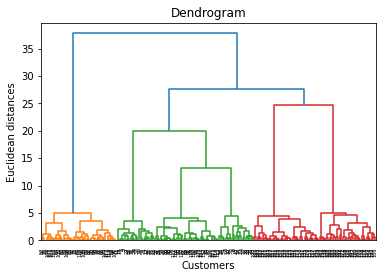

In [193]:
sch.dendrogram(sch.linkage(data_enc.values, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

First, we train the model and we'll identify a total of 6 clusters.

In [197]:
# Training the model with optimal no of clusters (determined in the previous section)
hierarchical_model = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage = 'ward')
hierarchical_model.fit(data_enc.values)
hierarchical_model_prediction = hierarchical_model.fit_predict(data_enc)

To assess the appropriateness of clustering results, we'll use the Silhouette Score, which measures how similar a point is to its own cluster as compared to other clusters.

In [198]:
metrics.silhouette_score(data_enc, hierarchical_model_prediction, metric = 'euclidean')

0.6200267012935324

Our silhouette score is 0.62, which is good as it is above 0; and considered a "reasonable" fit.


Now, let's visualize the clusters. As our data contains 4 features, we'll focus on the most important features to display in our scatter plots.

In our 3-dimensional plot, we'll focus on:
- Age
- Annual Income (k$)
- Spending Score

In our 2-dimensional plot, we'll focus on:
- Annual Income (k$)
- Spending Score

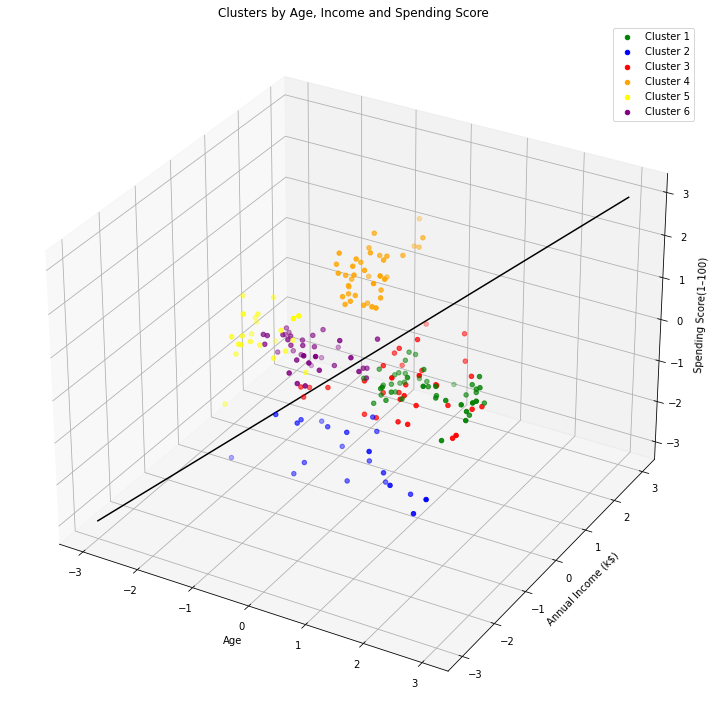

In [211]:
# Create plot
fig = plt.figure(figsize=(28,28))
kplot = fig.add_subplot(211, projection='3d')
#kplot = plt.axes(projection='3d')
xline = np.linspace(-3, 3, 1000)
yline = np.linspace(-3, 3, 1000)
zline = np.linspace(-3, 3, 1000)
kplot.plot3D(xline, yline, zline, 'black')


# Data for three-dimensional scattered points
kplot.scatter3D(data_enc.loc[hierarchical_model_prediction == 0]['Age'], data_enc.loc[hierarchical_model_prediction == 0]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 0]['Spending Score (1-100)'], c = 'green', label = 'Cluster 1')
kplot.scatter3D(data_enc.loc[hierarchical_model_prediction == 1]['Age'], data_enc.loc[hierarchical_model_prediction == 1]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 1]['Spending Score (1-100)'], c = 'blue', label = 'Cluster 2')
kplot.scatter3D(data_enc.loc[hierarchical_model_prediction == 2]['Age'], data_enc.loc[hierarchical_model_prediction == 2]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 2]['Spending Score (1-100)'], c = 'red', label = 'Cluster 3')
kplot.scatter3D(data_enc.loc[hierarchical_model_prediction == 3]['Age'], data_enc.loc[hierarchical_model_prediction == 3]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 3]['Spending Score (1-100)'], c = 'orange', label = 'Cluster 4')
kplot.scatter3D(data_enc.loc[hierarchical_model_prediction == 4]['Age'], data_enc.loc[hierarchical_model_prediction == 4]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 4]['Spending Score (1-100)'], c = 'yellow', label = 'Cluster 5')
kplot.scatter3D(data_enc.loc[hierarchical_model_prediction == 5]['Age'], data_enc.loc[hierarchical_model_prediction == 5]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 5]['Spending Score (1-100)'], c = 'purple', label = 'Cluster 6')
kplot.set_xlabel('Age')
kplot.set_ylabel('Annual Income (k$)')
kplot.set_zlabel('Spending Score(1–100)')
plt.legend()
plt.title("Clusters by Age, Income and Spending Score")
plt.show()

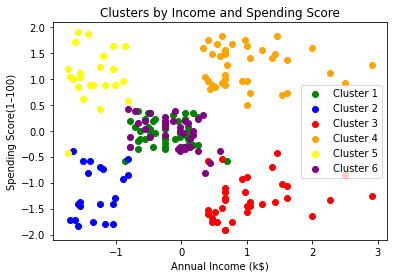

In [212]:
# visualizing the clusters
plt.scatter(data_enc.loc[hierarchical_model_prediction == 0]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 0]['Spending Score (1-100)'], c = 'green', label = 'Cluster 1')
plt.scatter(data_enc.loc[hierarchical_model_prediction == 1]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 1]['Spending Score (1-100)'], c = 'blue', label = 'Cluster 2')
plt.scatter(data_enc.loc[hierarchical_model_prediction == 2]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 2]['Spending Score (1-100)'], c = 'red', label = 'Cluster 3')
plt.scatter(data_enc.loc[hierarchical_model_prediction == 3]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 3]['Spending Score (1-100)'], c = 'orange', label = 'Cluster 4')
plt.scatter(data_enc.loc[hierarchical_model_prediction == 4]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 4]['Spending Score (1-100)'], c = 'yellow', label = 'Cluster 5')
plt.scatter(data_enc.loc[hierarchical_model_prediction == 5]['Annual Income (k$)'], data_enc.loc[hierarchical_model_prediction == 5]['Spending Score (1-100)'], c = 'purple', label = 'Cluster 6')
plt.title('Clusters by Income and Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score(1–100)')
plt.legend()
plt.show()

Visually, it seems the K-Means model is performing well at clustering based on the features highlighted in the 3d and 2d scatterplots. Let's take a look at some descriptive statistics now.

In [213]:
data_describeClusters = pd.DataFrame()

for i in range(0, 6):
    d = {'Cluster #': i+1, 'Count': data[hierarchical_model_prediction == i].describe().iloc[0, 0]}
    d.update(data[hierarchical_model_prediction == i].describe().iloc[1, :])
    d.update(data[hierarchical_model_prediction == i].describe(include = "O").iloc[3] / data[hierarchical_model_prediction == i].describe().iloc[0, 0])
    
    data_describeClusters = data_describeClusters.append(d, ignore_index=True)

data_describeClusters

C:\Users\SFortin1\AppData\Local\Temp\1\ipykernel_22564\835207859.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\SFortin1\AppData\Local\Temp\1\ipykernel_22564\835207859.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\SFortin1\AppData\Local\Temp\1\ipykernel_22564\835207859.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\SFortin1\AppData\Local\Temp\1\ipykernel_22564\835207859.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\SFortin1\AppData\Local\Temp\1\ipykernel_22564\835207859.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version

,Cluster #,Count,Age,Annual Income (k$),Spending Score (1-100),Gender
0,1.0,45.0,56.333333,54.266667,49.066667,0.577778
1,2.0,21.0,45.523810,26.285714,19.380952,0.619048
2,3.0,34.0,41.264706,88.500000,16.764706,0.588235
3,4.0,39.0,32.692308,86.538462,82.128205,0.538462
4,5.0,23.0,25.000000,25.260870,77.608696,0.565217
5,6.0,38.0,27.000000,56.657895,49.131579,0.657895


Based on these descriptive analyses, the 6 clusters identified through K-means clustering can be categorized as follows:

| Cluster   | Age   | Income | Spending Score | Gender |
| --------- | ----- | ------ | -------------- | ------ |
| Cluster 1 | Old   | Mid    | Mid            | Mixed  |
| Cluster 2 | Mid   | Low    | Low            | Mixed  |
| Cluster 3 | Mid   | High   | Low            | Mixed  |
| Cluster 4 | Mid   | High   | High           | Mixed  |
| Cluster 5 | Young | Low    | High           | Mixed  |
| Cluster 6 | Young | Mid    | Mid            | Mixed  |

In reviewing the Silhouette score, the visualizations, and the descriptive analyses, it appears that hierarchical clustering and K-means clustering have created identical clusters (albeit, as expected, the cluster labels are different).

We'll discuss how identifying these customer segments may be impactful to the business in the Conclusion section of this project.

### DBSCAN Clustering

In this section, we will perform density-based clustering using DBSCAN.

In order to train the model, we need to first determine the value for our hyperparameters.
- eps: epsilon (radius), which we can solve for using the elbow method
- min_samples: minimum number of points, a rule of thumb is that the minimum value is equal to the number of features + 1

First, we'll find the optimal epsiolon (radius) using the elbow method.

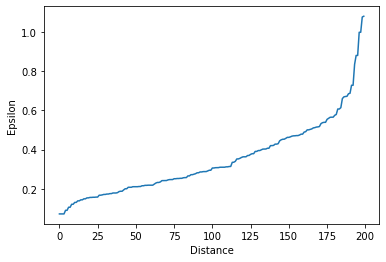

In [216]:
# Calculate distances
nn = NearestNeighbors(n_neighbors=2)
distance = nn.fit(data_enc)
distances, indices = distance.kneighbors(data_enc)
sorted_distances = np.sort(distances, axis = 0)
sorted_distances = sorted_distances[:, 1]

# Plot sorted distances
plt.plot(sorted_distances)
plt.xlabel('Distance')
plt.ylabel('Epsilon')
plt.show()

We observe an inflection point in the figure above when Epsilon is approximately equal to 0.7. As such, we will select 0.7 as the value of the epsilon hyperparamter.

Now let's train our model using an epsilon value of 0.6 and setting min_samples to the number of features + 1 (5).

In [258]:
# Training the model
DBSCAN_model = DBSCAN(eps = 0.7, min_samples = 5)
DBSCAN_model.fit(data_enc)
DBSCAN_model_predict = DBSCAN_model.labels_

To assess the appropriateness of clustering results, we'll use the Silhouette Score, which measures how similar a point is to its own cluster as compared to other clusters.

In [259]:
metrics.silhouette_score(data_enc, DBSCAN_model_predict, metric = 'euclidean')

0.18449093344806328

Our silhouette score is 0.18, which is not "bad" but indicates that the fit of the clusters is extremely weak.


Now, let's visualize the clusters. As our data contains 4 features, we'll focus on the most important features to display in our scatter plots.

In our 3-dimensional plot, we'll focus on:
- Age
- Annual Income (k$)
- Spending Score

In our 2-dimensional plot, we'll focus on:
- Annual Income (k$)
- Spending Score

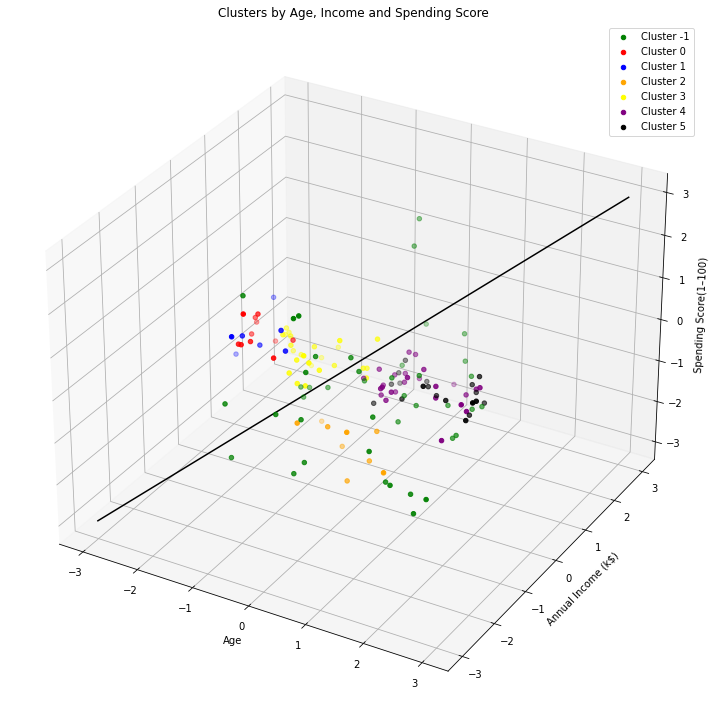

In [262]:
colors = ['green', 'red', 'blue', 'orange', 'yellow', 'purple', 'black']

# Create plot
fig = plt.figure(figsize=(28,28))
kplot = fig.add_subplot(211, projection='3d')
#kplot = plt.axes(projection='3d')
xline = np.linspace(-3, 3, 1000)
yline = np.linspace(-3, 3, 1000)
zline = np.linspace(-3, 3, 1000)
kplot.plot3D(xline, yline, zline, 'black')

# Data for three-dimensional scattered points
for l, color in zip(np.unique(DBSCAN_model_predict), colors):
    kplot.scatter3D(data_enc.loc[DBSCAN_model_predict == l]['Age'], data_enc.loc[DBSCAN_model_predict == l]['Annual Income (k$)'], data_enc.loc[DBSCAN_model_predict == l]['Spending Score (1-100)'], c = color, label = 'Cluster ' + str(l))
kplot.set_xlabel('Age')
kplot.set_ylabel('Annual Income (k$)')
kplot.set_zlabel('Spending Score(1–100)')
plt.legend()
plt.title("Clusters by Age, Income and Spending Score")
plt.show()

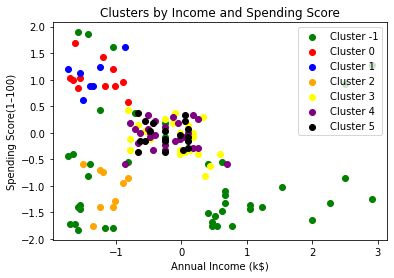

In [263]:
colors = ['green', 'red', 'blue', 'orange', 'yellow', 'purple', 'black']

# visualizing the clusters
for l, color in zip(np.unique(DBSCAN_model_predict), colors):
    plt.scatter(data_enc.loc[DBSCAN_model_predict == l]['Annual Income (k$)'], data_enc.loc[DBSCAN_model_predict== l]['Spending Score (1-100)'], c = color, label = 'Cluster ' + str(l))
plt.title('Clusters by Income and Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score(1–100)')
plt.legend()
plt.show()

We can see from the visualizations that several data points are not assigned to a cluster (cluster value equal to -1). Also, there are several apparent clusters of points in the graph that have multiple colors indicating that cluster segmentation is not performing well.

It is important to note that a wide range of epsilon values (0.6 to 0.8) and min_samples values (5 to 10) were tested outside of this notebook. Modifying these parameters did not lead to significant improvements in model performance, but at times led to significant decreases in performance.

Given the poor performance of DBSCAN, there is no need to further describe the clusters identified by DBSCAN. It is apparent that K-Means Clustering and Hiearchical Clustering, which yielded identical results, vastly outperformed DBSCAN and should be considered the preferred models for this project.

## Discussion and Conclusion

In this project, data on the age, annual income, spending score, and gender of 200 customers was provided. The primary objective of this study was to leverage this data to identify customer segments. The purpose of identifying customer segments was to support marketing activities, potentially including:
- Identification of high-value customer segments for targeted campaigns
- Enhance customer satisfaction and engagement by personalizing ad campaigns
- Optimize marketing spend by focusing on high-value customers
- Improve customer retention by better addressing the needs of customer segments

To identify customer segments, we used a total of 3 unsupervised learning approaches: K-Means Clustering, Hierarchical Clustering, and DBSCAN Clustering. Both K-Means Clustering and Hierarchical Clustering divided customers into the same customer segments and the clusters had a reasonably good fit as indicate by a Silhouette score of 0.62. In contrast, DBSCAN Clustering failed to classify several patients and the clusters had an extremely weak fit as indicated by a Silhouette score of 0.18. As a result, we recommend using the customer segments identified by K-Means CLustering and Hierarchical Clustering to support marketing activities.

A summary of the 6 customer segments identified by K-Mean Clustering and Hierarchical Clustering, which were identical between methods, is shown in the table below.

| Cluster   | Age   | Income | Spending Score | Gender |
| --------- | ----- | ------ | -------------- | ------ |
| Cluster 1 | Old   | Mid    | Mid            | Mixed  |
| Cluster 2 | Mid   | Low    | Low            | Mixed  |
| Cluster 3 | Young | Mid    | Mid            | Mixed  |
| Cluster 4 | Young | Low    | High           | Mixed  |
| Cluster 5 | Mid   | High   | High           | Mixed  |
| Cluster 6 | Mid   | High   | Low            | Mixed  |

Based on these customer segments, it appears that there are two high-value customer segments with a high spending score. These segments include young, low income individuals and middle-aged, high-income individuals. These segments of customers may represent attractive targets for targeted campaigns.

We also observe a customer segment comprised of middle-aged, low income customers with a low spending score. There may be an opportunity to review marketing activities to ensure that this customer segment is being appropriately engaged, and to develop strategies to drive up engagement among this customer segment.

We hope that these findings will help to improve customer experience and increase returns on investment by developing more targeted, personalized ads that can be better targeted to high value customers.

## Github Repository

The github repository for this project is available at the following link: https://github.com/sfortin1/FinalProject_UnsupervisedLearning.